In [1]:
# General imports
import os
import sys
import pandas as pd
import scipy
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
from tqdm import tqdm
sys.path.append('../')
# Other imports

tqdm.pandas()
import yaml
import json

# Figures imports
import matplotlib
from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager
import string

from pandarallel import pandarallel

pandarallel.initialize(nb_workers=30, progress_bar=True)


## YAML FILES CONFIG
yaml = yaml.load(open("config/config_files.yaml"), Loader=yaml.FullLoader)
base_dir = yaml['base_directory']
sys.exit('EXIT : Need to specify the base_directory in config file : "conf_files.yaml"') if base_dir == 'TO_CHANGE' else None
    


# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

pvalues_cutoff = json.load(open('config/config_files.json'))['pvalues_cutoff']
pvalues_cutoff = [[e, str(e)] for e in pvalues_cutoff]

import matplotlib.font_manager as font_manager

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 18

INFO: Pandarallel will run on 30 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [2]:
genes = pd.read_parquet("/gstock/GeneIso/V2/Genes.parquet")
mrna = pd.read_parquet("/gstock/GeneIso/V2/mRNA.parquet")
exons = pd.read_parquet("/gstock/GeneIso/V2/Exons.parquet")
cds = pd.read_parquet("/gstock/GeneIso/V2/CDS.parquet")
five_UTR = pd.read_parquet("/gstock/GeneIso/V2/5_UTR.parquet")
three_UTR = pd.read_parquet("/gstock/GeneIso/V2/3_UTR.parquet")
introns = pd.read_parquet("/gstock/GeneIso/V2/Introns.parquet")
#TODO
introns.loc[introns['Strand'] == 1, 'Ordinal_nb_inverted'] = introns.loc[introns['Strand'] == 1, 'Ordinal_nb_inverted'] + 1

In [4]:
plt.rcParams.update({'font.size' : 18})

def custom_boxplot(data, x, y, hue, ax, ylim, title="Title",xlabel="",ylabel="", box_pairs=[()], palette=['grey'], id_string="A", padding_value_boxplot=1, padding_title=10, legend=False, x_legend=0):

    data = data.sort_values(by=hue,ascending=True)
    count = data.groupby([hue, x]).count()['GeneID'].reset_index().pivot(columns=[hue],values='GeneID',index=x).reset_index()
    count['Miso'] = count['Miso'].apply(lambda r: str(format(int(r), ',')))
    count['Siso'] = count['Siso'].apply(lambda r: str(format(int(r), ',')))
    count['Miso/Siso'] = count[x].astype(str) + '\n(' + count['Miso'] + ' / ' + count['Siso'] + ')'
    
    
    bw = 0.2
    cut = 0
    lw = 1.5

    box = sns.violinplot(data=data, x=x, y=y, hue=hue, showfliers=False, ax=ax, cut=cut, linewidth=lw, bw=bw, scale='width', alpha=0.3)

    plt.setp(box.collections, alpha=.3)

        
    ax.set_title(title, pad=padding_title)
    ax.set_ylim(ylim)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Length (bp)')
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    ax.set_xticklabels(count['Miso/Siso'].values.tolist(), fontsize=14)
    
    if not x: 
        ax.spines['bottom'].set_linewidth(0)
        ax.axes.xaxis.set_visible(False)
        
    ax.set_axisbelow(True)
    ax.grid(axis='y')
    
    if legend is True:
    
        handles, labels = ax.get_legend_handles_labels()

        ax.legend(handles= 
                  [ 
                    mpatches.Patch([0], [0], color=palette['Miso'], ),
                    mpatches.Patch([0], [0], color=palette['Siso'], ),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15),
#                     matplotlib.lines.Line2D([0], [0], marker='s', color='w', label='Circle', markerfacecolor='grey', markeredgecolor='black', markersize=15)
                    ],  
              labels= ['MISOG', 'SISOG', "Median"], title='', ncol=3, bbox_to_anchor=(0.5,-1), loc='center right')
    else:
        ax.legend().remove()

    means = data.groupby([hue, x])[y].quantile(0.75).reset_index()
    medians = data.groupby([hue, x])[y].quantile(0.5).reset_index()
    for ms, x_shift in zip(['Miso', 'Siso'], [-0.2,0.2]):
        tmp_df_medians = medians.loc[medians['Miso_siso'] == ms]
        tmp_df_means = means.loc[means['Miso_siso'] == ms]
        x_plot = [e + x_shift for e in range(0,5)]
        if 'Introns' in title :
            ax.plot(x_plot, tmp_df_means[y].values, lw=2.5, color=palette[ms],  marker="s", markersize=8, markeredgecolor="black",  markeredgewidth=1, ls='-', )
            ax.plot(x_plot, tmp_df_medians[y].values, lw=2.5, color="white",  marker="o", markersize=6, markeredgecolor="black",  markeredgewidth=1, ls='', )
        else:
            ax.plot(x_plot, tmp_df_medians[y].values, lw=2.5, color=palette[ms],  marker="o", markersize=10, markeredgecolor="black",  markeredgewidth=1, ls='-', )

    add_stat_annotation(ax, data=data, x=x, y=y, hue=hue, box_pairs=box_pairs,
                        test='Mann-Whitney', text_format='simple',  pvalue_thresholds=pvalues_cutoff,
                        loc='outside', fontsize=9, verbose=2, line_height=0.0025, line_offset=0.012)

    return ax

In [12]:
exons_merge = pd.merge(genes[['GeneID', 'transcript_count']], exons, on='GeneID')
cds_merge = pd.merge(genes[['GeneID', 'transcript_count']], cds, on='GeneID')
introns_merge = pd.merge(genes[['GeneID', 'transcript_count']], introns, on='GeneID')
five_UTR_merge = pd.merge(genes[['GeneID', 'transcript_count']], five_UTR, on='GeneID')


[((1, 'Miso'), (1, 'Siso')), ((2, 'Miso'), (2, 'Siso')), ((3, 'Miso'), (3, 'Siso')), ((4, 'Miso'), (4, 'Siso')), ((5, 'Miso'), (5, 'Siso')), ((1, 'Miso'), (2, 'Miso')), ((1, 'Miso'), (3, 'Miso')), ((1, 'Miso'), (4, 'Miso')), ((1, 'Miso'), (5, 'Miso')), ((1, 'Siso'), (2, 'Siso')), ((1, 'Siso'), (3, 'Siso')), ((1, 'Siso'), (4, 'Siso')), ((1, 'Siso'), (5, 'Siso'))]
2_Miso v.s. 2_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.706e-64 U_stat=6.668e+07
1_Miso v.s. 1_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.990e-66 U_stat=6.673e+07
3_Miso v.s. 3_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.410e-22 U_stat=6.060e+07
4_Miso v.s. 4_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.826e-13 U_stat=5.113e+07
5_Miso v.s. 5_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.098e-04 U_stat=4.253e+07
1_Miso v.s. 2_Miso: Mann-Whitney-Wilcoxon tes

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


-4.0_Miso v.s. -4.0_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.235e+02
-5.0_Miso v.s. -5.0_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.950e+01
-3.0_Miso v.s. -3.0_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=9.145e+02
-2.0_Miso v.s. -2.0_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.937e+05
-1.0_Miso v.s. -1.0_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.809e-105 U_stat=6.079e+07
-2.0_Miso v.s. -1.0_Miso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=0.000e+00 U_stat=4.570e+06
-2.0_Siso v.s. -1.0_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.796e-79 U_stat=1.076e+04
-3.0_Miso v.s. -1.0_Miso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.648e-89 U_stat=1.045e+06
-3.0_Si

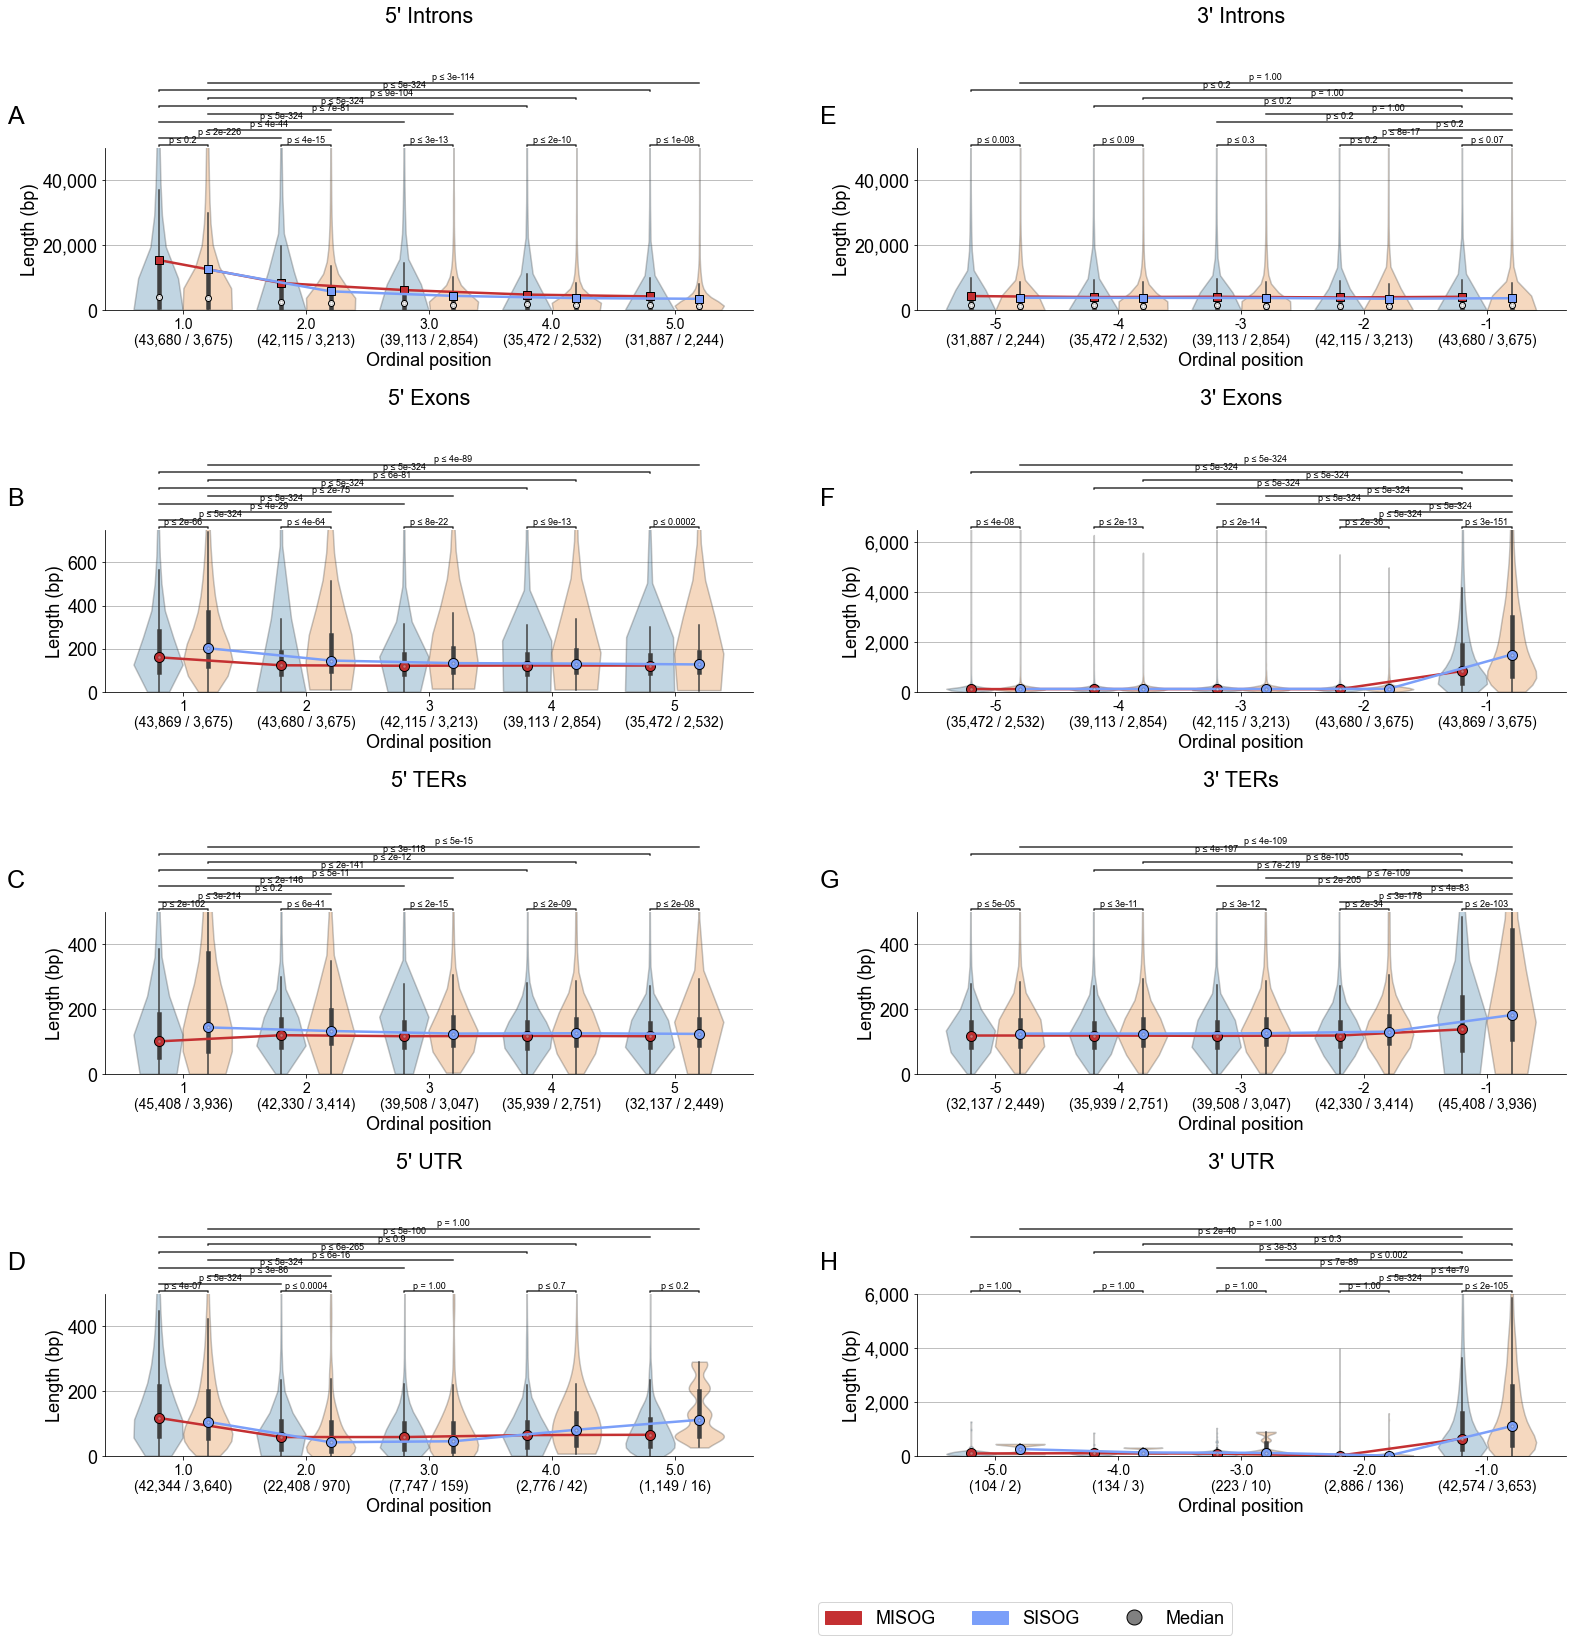

In [15]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(22,25))
palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }
box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in range(1,6)
]

box_pairs = box_pairs + [((1,'Miso'),(e,'Miso')) for e in range(2,6)] + [((1,'Siso'),(e,'Siso')) for e in range(2,6)]

print(box_pairs)

k_limit = 5
zscore_cutoff = 2
padding_title = 125


custom_boxplot(data=exons.loc[(exons['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', ax=ax[1][0], ylim=(0,750), xlabel='Ordinal position', palette=palette, title="5' Exons", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=cds.loc[(cds['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', xlabel='Ordinal position', ax=ax[2][0], ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' TERs", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=introns.loc[(introns['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', ax=ax[0][0], xlabel='Ordinal position', ylim=(0,5e4), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' Introns", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=five_UTR.loc[(five_UTR['Ordinal_nb'] <= 5)], x='Ordinal_nb', y='Length', hue='Miso_siso', ax=ax[3][0], xlabel='Ordinal position', ylim=(0,500), palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }, title="5' UTR", box_pairs=box_pairs, padding_title=padding_title)


box_pairs = [
    ((e,'Miso'),(e,'Siso')) for e in list(range(-5,0))
]
box_pairs = box_pairs + [((-1,'Miso'),(e,'Miso')) for e in range(-5,-1)] + [((-1,'Siso'),(e,'Siso')) for e in range(-5,-1)]

custom_boxplot(data=exons.loc[(exons['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso',xlabel='Ordinal position', ax=ax[1][1], ylim=(0,6.5e3), palette=palette, title="3' Exons", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=cds.loc[(cds['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso', xlabel='Ordinal position',ax=ax[2][1], ylim=(0,500), palette=palette, title="3' TERs", box_pairs=box_pairs, padding_title=padding_title)
custom_boxplot(data=introns.loc[(introns['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso',xlabel='Ordinal position', ax=ax[0][1], ylim=(0,50e3), palette=palette, title="3' Introns", box_pairs=box_pairs, padding_title=padding_title, )
custom_boxplot(data=three_UTR.loc[(three_UTR['Ordinal_nb_inverted'] >= -5)], x='Ordinal_nb_inverted', y='Length', hue='Miso_siso',  xlabel='Ordinal position',ax=ax[3][1], ylim=(0,6e3), palette=palette, title="3' UTR", box_pairs=box_pairs, padding_title=padding_title, legend=True, x_legend=1.35,)


i = 0
for n, a in enumerate(ax):
    print(a)
    sub_a = a[0]
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1
for n, a in enumerate(ax):
    sub_a = a[1]
    sub_a.text(-0.15, 1.15, string.ascii_uppercase[i], transform=sub_a.transAxes, size=25, weight='bold')
    i += 1

plt.tight_layout()

# figure_path = base_dir + yaml['Figures']['FigS1']
# f.savefig(figure_path, dpi=600)

                      count          mean           std  min     25%     50%  \
Miso_siso variable                                                             
Miso      START     43795.0  12857.999726  42141.271056  0.0  117.00   790.0   
          STOP      43795.0   1656.916178   4694.361527  0.0  249.00   706.0   
Siso      START      3414.0   3927.972173  17017.048926  3.0   61.00   142.0   
          STOP       3414.0   2107.785003   5086.542323  4.0  430.25  1166.5   

                        75%        max  
Miso_siso variable                      
Miso      START     8473.50  1879159.0  
          STOP      1809.50   270375.0  
Siso      START      520.75   371086.0  
          STOP      2672.75   175522.0  
STOP_Miso v.s. STOP_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.487e-81 U_stat=6.008e+07
START_Miso v.s. START_Siso: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.991e-220 U_stat=9.905e+07


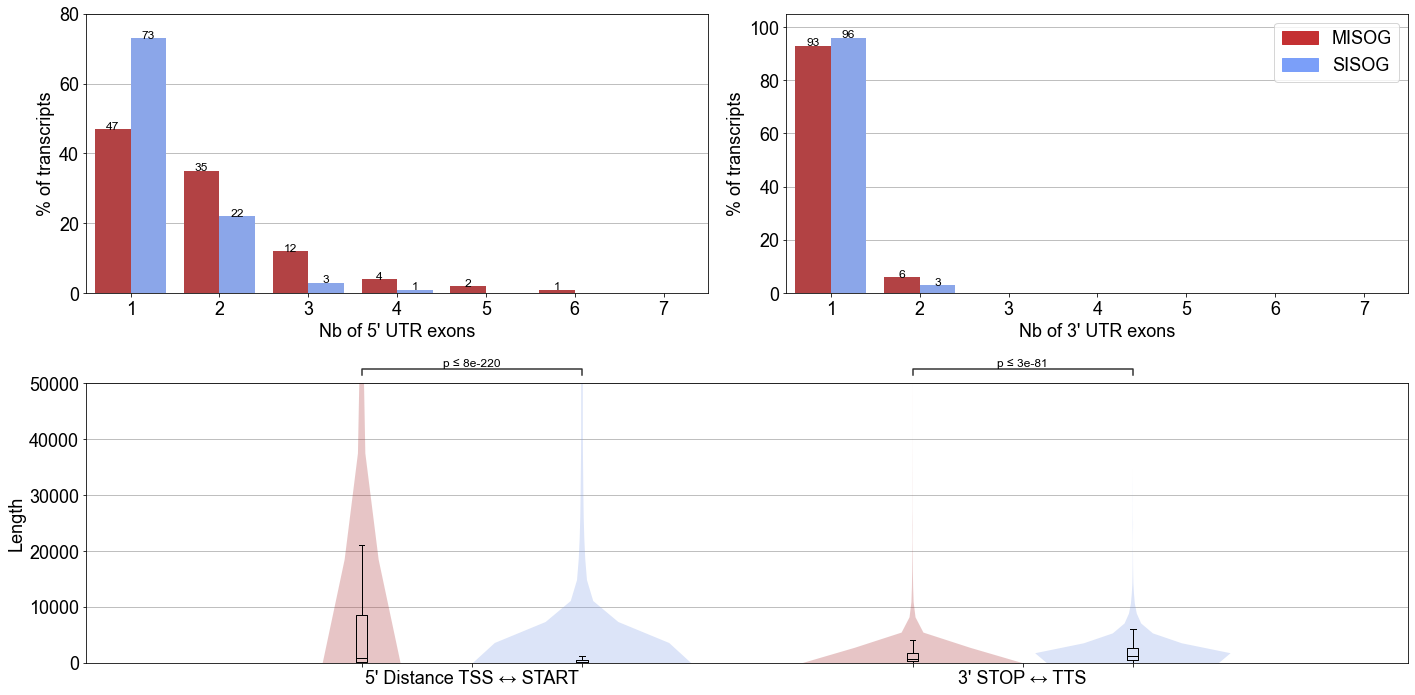

In [27]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            if np.isnan(p.get_height()) == False and p.get_height() > 0.4:
                value = '{:0}'.format(int(p.get_height()))
                ax.text(_x, _y, value, ha="center", fontsize=12) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

fig = plt.figure(figsize=(20, 10)) 
gs = matplotlib.gridspec.GridSpec(2, 2, width_ratios=[1, 1]) 
ax00 = plt.subplot(gs[0,0])
ax01 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0:])



data_5_prime = 100 * ( five_UTR.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["5' UTR start"].count().reset_index().groupby('Miso_siso')["5' UTR start"].value_counts() / five_UTR.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["5' UTR start"].count().reset_index().groupby('Miso_siso')["5' UTR start"].value_counts().groupby('Miso_siso').sum())
data_5_prime = data_5_prime.rename('count').reset_index()
data_5_prime = data_5_prime.loc[data_5_prime["5' UTR start"] <= 7]
data_5_prime = data_5_prime.round()
data_3_prime = 100 * ( three_UTR.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["3' UTR start"].count().reset_index().groupby('Miso_siso')["3' UTR start"].value_counts() / three_UTR.groupby(['Miso_siso', 'GeneID', 'transcript_id'])["3' UTR start"].count().reset_index().groupby('Miso_siso')["3' UTR start"].value_counts().groupby('Miso_siso').sum())
data_3_prime = data_3_prime.rename('count').reset_index()
data_3_prime = data_3_prime.loc[data_3_prime["3' UTR start"] <= 7]
data_3_prime = data_3_prime.round()


sns.barplot(data=data_5_prime, x="5' UTR start", y='count', hue='Miso_siso', palette=palette, ax=ax00)
sns.barplot(data=data_3_prime, x="3' UTR start", y='count', hue='Miso_siso', palette=palette, ax=ax01)


show_values_on_bars(ax00)
show_values_on_bars(ax01)


ax00.set_ylim(ymax=80)
ax01.set_ylim(ymax=105)
ax00.set_ylabel("% of transcripts")
ax00.set_xlabel("Nb of 5' UTR exons")
ax01.set_ylabel("% of transcripts")
ax01.set_xlabel("Nb of 3' UTR exons")
# ax00.legend(loc='upper right', handles = [mpatches.Patch(color=palette['Miso']), mpatches.Patch(color=palette['Siso'])], labels=['M-iso', 'S-iso'])
ax01.legend(loc='upper right', handles = [mpatches.Patch(color=palette['Miso']), mpatches.Patch(color=palette['Siso'])], labels=['MISOG', 'SISOG'])

ax00.legend().remove()

l_axes = [ax00, ax01, ax3]

palette={'Miso' : '#C43032FF', 'Siso' : '#7B9FF9FF', }


distance_tss_start_strand_positive = (cds.loc[cds['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_start_abs'].min() - exons.loc[exons['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region start (bp)'].min())
distance_tss_start_strand_negative = (exons.loc[exons['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region end (bp)'].max() - cds.loc[cds['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_end_abs'].max())
tss_start = pd.concat([distance_tss_start_strand_positive, distance_tss_start_strand_negative]).rename('Length').reset_index()
tss_start['Distance_START_STOP'] = 'START'

distance_tts_stop_strand_positive = (exons.loc[exons['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region end (bp)'].max() - cds.loc[cds['Strand'] == 1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_end_abs'].max())
distance_tts_stop_strand_negative = (cds.loc[cds['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['CDS_start_abs'].min() - exons.loc[exons['Strand'] == -1].groupby(['Miso_siso', 'GeneID', 'transcript_id'])['Exon region start (bp)'].min())
tts_stop = pd.concat([distance_tts_stop_strand_positive, distance_tts_stop_strand_negative]).rename('Length').reset_index()
tts_stop['Distance_START_STOP'] = 'STOP'

tss_tts_final_df = pd.concat([tss_start, tts_stop])

t = cds[['GeneID', 'Exon region start (bp)', 'Exon region end (bp)', 'CDS start', 'CDS end']].drop_duplicates().groupby('GeneID')['CDS start'].count()

tss_tts_final_df = tss_tts_final_df.loc[~tss_tts_final_df['GeneID'].isin(t[t == 1].index.tolist())]


data = tss_tts_final_df.rename({'Distance_START_STOP' : 'variable', 'Length' : 'value'}, axis=1)


bw = 0.25
cut = 0.05
lw = 0


x, y, hue = 'variable', 'value', 'Miso_siso'
print(data.groupby(['Miso_siso', 'variable'])['value'].describe())

box =sns.violinplot(data=data, x='variable', y='value', hue='Miso_siso', showfliers=True, palette=palette, ax=ax3, bw=bw, cut=cut, linewidth=lw)
plt.setp(box.collections, alpha=.3)



box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Miso') & (data['variable'] == 'START')]['value'], positions=[-0.2], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})
# for patch in box.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .1))
box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Siso') & (data['variable'] == 'START')]['value'], positions=[+0.2], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})
# for patch in box.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .1))
box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Miso') & (data['variable'] == 'STOP')]['value'], positions=[0.8], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})
# for patch in box.artists:
#     r, g, b, a = patch.get_facecolor()
#     patch.set_facecolor((r, g, b, .1))
box = plt.boxplot(data.loc[(data['Miso_siso'] == 'Siso') & (data['variable'] == 'STOP')]['value'], positions=[1.2], showfliers=False, widths=[0.02],
                 medianprops={"color":'black'})

ax3.set_xticklabels(["5' Distance TSS ↔ START", "3' STOP ↔ TTS"])
ax3.set_ylabel('Length')
ax3.set_xlabel('')
ax3.legend().remove()
box_pairs = [
    (('START', 'Miso'), ('START', 'Siso')),
    (('STOP', 'Miso'), ('STOP', 'Siso')),
]
ax3.set_ylim(0,0.5e5)

add_stat_annotation(ax3, data=data, x='variable', y='value', hue='Miso_siso', box_pairs=box_pairs, test='Mann-Whitney', text_format='simple', loc='outside', pvalue_thresholds=pvalues_cutoff, fontsize=12,)
# ax.text(-0.1, 1.15, string.ascii_uppercase[i], transform=ax3.transAxes, size=25, weight='bold')



for ax in l_axes:
    ax.grid(axis='y')
    ax.set_axisbelow(True)

plt.tight_layout()

# figure_path = base_dir + yaml['Figures']['Fig2']
# fig.savefig(figure_path, dpi=600)
